# Import libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm
pd.set_option('display.max_columns', 100)

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Import and read data

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
ss = pd.read_csv('sample_submission.csv')

In [3]:
display(df_train.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print("Training set shape: ", df_train.shape)
print("Test set shape: ", df_test.shape)

Training set shape:  (1460, 81)
Test set shape:  (1459, 80)


# Exploratory Data Analysis (EDA)

In [5]:
# Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace=True)
df_test.drop("Id", axis = 1, inplace=True)

## Target Variable

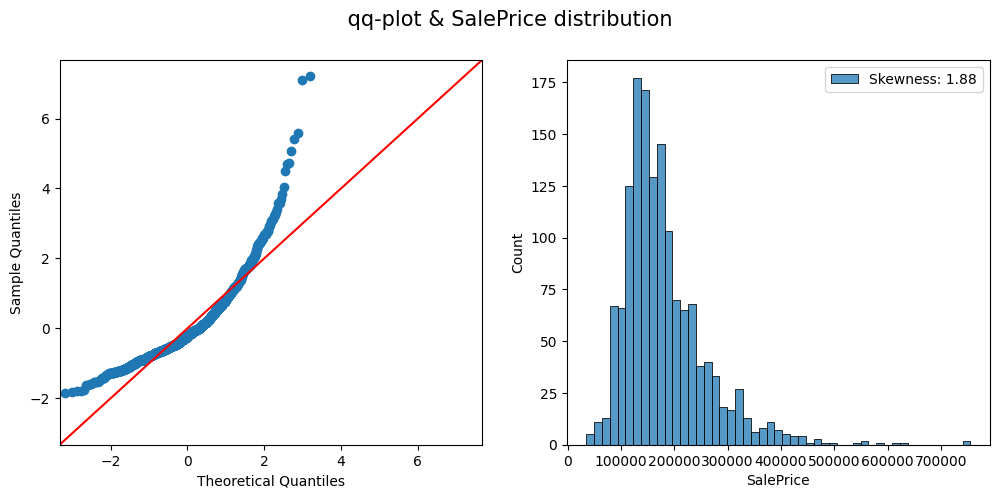

In [6]:
# Target variable distribution
fig, ax = plt.subplots(1,2, figsize= (12,5))
fig.suptitle(" qq-plot & SalePrice distribution ", fontsize= 15)
sm.qqplot(df_train['SalePrice'], stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.histplot(df_train['SalePrice'], label = 'Skewness: %.2f'%(df_train['SalePrice'].skew()), ax = ax[1])
plt.legend(loc = 'best')
plt.show()

Os dados da variável SalePrice não seguem uma distribuição normal. Aplicando uma transformação logarítmica na variável aproximando a de uma distribuição normal, os modelos de regressão podem ter um desempenho melhor em seu treinamento.

In [7]:
# New target variable with log tranformation
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

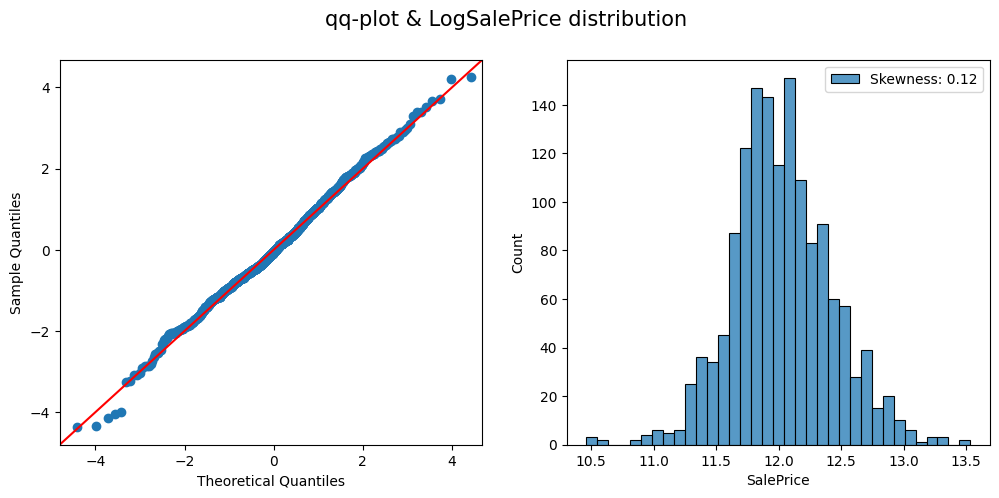

In [8]:
# Target variable distribution after log transformation
fig, ax = plt.subplots(1,2, figsize= (12,5))
fig.suptitle("qq-plot & LogSalePrice distribution ", fontsize= 15)
sm.qqplot(df_train['SalePrice'], stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.histplot(df_train['SalePrice'], label = 'Skewness: %.2f'%(df_train['SalePrice'].skew()), ax=ax[1])
plt.legend(loc = 'best')
plt.show()

## Missing values

Muitos valores NAs são uma categoria e não valores ausentes!

### Concat both datasets

In [9]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train['SalePrice']
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


In [10]:
all_data.isnull().sum().sort_values(ascending=False)[:10] / len(all_data) * 100

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
FireplaceQu     48.646797
LotFrontage     16.649538
GarageYrBlt      5.447071
GarageFinish     5.447071
GarageQual       5.447071
GarageCond       5.447071
dtype: float64

**Atualizando os valores NAs de acordo com o dicionário de dados.**

In [11]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish',
            'GarageQual', 'BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtQual', 'BsmtFinType1', 'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

for col in ('LotFrontage','GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath',
            'BsmtHalfBath', 'GarageCars', 'GarageArea'):
    all_data[col] = all_data[col].fillna(0)

**Esse são os valores faltantes!**

In [12]:
all_data.isnull().sum().sort_values(ascending=False)[:10] / len(all_data) * 100

MSZoning        0.137033
Utilities       0.068517
Functional      0.068517
Electrical      0.034258
KitchenQual     0.034258
Exterior1st     0.034258
Exterior2nd     0.034258
SaleType        0.034258
BsmtFullBath    0.000000
GrLivArea       0.000000
dtype: float64

### Impute values

In [13]:
# Mode
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Utilities'] = all_data['Utilities'].fillna(all_data['MSZoning'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

## Checking for constant variables

In [14]:
c = 0
print('== all_data ==')
for col in all_data.copy():
    rate = all_data[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.98:
        c += 1
        del all_data[col]
print(f'Remove {c} variables.')

== all_data ==
Remove 9 variables.


In [15]:
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

## Categorical Variables

In [16]:
cat_vars = list(df_train.select_dtypes(include='O').columns)

In [17]:
# Summary statistics
display(df_train.select_dtypes(include='O').describe())

,MSZoning,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,3,4,4,5,3,25,9,5,8,6,15,16,4,4,5,6,5,5,5,7,7,5,2,5,4,7,6,7,4,6,6,3,5,5,9,6
top,RL,None,Reg,Lvl,Inside,Gtl,NAmes,Norm,1Fam,1Story,Gable,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,Ex,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,None,None,WD,Normal
freq,1151,1369,925,1311,1052,1382,225,1260,1220,726,1141,515,504,872,906,1282,647,649,1311,953,430,1256,741,1365,1335,735,1360,690,870,605,1311,1326,1340,1179,1406,1267,1198


### Univariate Analysis

In [18]:
display(df_train.BsmtFinType1.value_counts(normalize=True)[:5])
display(df_test.BsmtFinType1.value_counts(normalize=True)[:5])

Unf    0.294521
GLQ    0.286301
ALQ    0.150685
BLQ    0.101370
Rec    0.091096
Name: BsmtFinType1, dtype: float64

GLQ    0.295408
Unf    0.288554
ALQ    0.143249
Rec    0.106237
BLQ    0.082934
Name: BsmtFinType1, dtype: float64

In [19]:
# Electrical variable contains 1 "mix" observation but we don't have it in the test dataset, I decided to remove it.
display(df_train.Electrical.value_counts())
display(df_test.Electrical.value_counts())

#df_train.query('Electrical == "Mix"')
df_train.drop(index=398, inplace=True)
y_train.drop(index=398, inplace=True)

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64

In [20]:
# df_train contains 8 "2.5Fin" observations but we don't have it in the test dataset, I decided to remove it.
display(df_train.HouseStyle.value_counts()[:5])
display(df_test.HouseStyle.value_counts()[:5])

#df_train.query('HouseStyle == "2.5Fin"')
idx_house_style = [185, 198, 267, 304, 635, 883, 1031, 1440]
df_train.drop(index=idx_house_style, inplace=True)
y_train.drop(index=idx_house_style, inplace=True)

1Story    725
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
Name: HouseStyle, dtype: int64

1Story    745
2Story    427
1.5Fin    160
SLvl       63
SFoyer     46
Name: HouseStyle, dtype: int64

In [21]:
# df_train contains 1 "ImStucc" and 2 "Stone" observations but we don't have it in the test dataset, I decided to remove it.
display(df_train.Exterior1st.value_counts()[:5])
display(df_test.Exterior1st.value_counts()[:5])

#df_train.query('Exterior1st == "ImStucc" and Exterior1st == "Stone"')
idx_exterior1st = [1024, 1152, 1187]
df_train.drop(index=idx_exterior1st, inplace=True)
y_train.drop(index=idx_exterior1st, inplace=True)

VinylSd    514
HdBoard    222
MetalSd    218
Wd Sdng    201
Plywood    108
Name: Exterior1st, dtype: int64

VinylSd    511
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
Name: Exterior1st, dtype: int64

In [22]:
# df_train contains 1 "other" observation but we don't have it in the test dataset, I decided to remove it.
display(df_train.Exterior2nd.value_counts()[:5])
display(df_test.Exterior2nd.value_counts()[:5])

#df_train.query('Exterior2nd == "Other"')
df_train.drop(index=595, inplace=True)
y_train.drop(index=595, inplace=True)

VinylSd    503
MetalSd    212
HdBoard    206
Wd Sdng    193
Plywood    141
Name: Exterior2nd, dtype: int64

VinylSd    511
MetalSd    233
HdBoard    199
Wd Sdng    194
Plywood    128
Name: Exterior2nd, dtype: int64

In [23]:
display(df_train.MiscFeature.value_counts())
display(df_test.MiscFeature.value_counts())

#df_train.query('MiscFeature == "TenC"')
df_train.drop(index=1386, inplace=True)
y_train.drop(index=1386, inplace=True)

None    1393
Shed      49
Gar2       2
Othr       2
TenC       1
Name: MiscFeature, dtype: int64

None    1408
Shed      46
Gar2       3
Othr       2
Name: MiscFeature, dtype: int64

## Numerical Variables

In [24]:
num_vars = list(df_train.select_dtypes(exclude='O').columns)

In [25]:
display(df_train.select_dtypes(exclude='O').describe())

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,MoSold,YrSold
count,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,56.839557,57.477178,10495.013140,6.094053,5.571231,1971.598202,1984.885201,103.823651,443.587828,46.020747,566.905256,1056.513831,1159.148686,343.188797,1506.067082,0.425311,0.058091,1.562241,0.383817,2.857538,1.046335,6.490318,0.609959,1870.426003,1.766943,472.520747,94.250346,46.271093,21.699170,14.535961,42.526971,6.318811,2007.822268
std,42.292496,34.716835,10016.462009,1.380840,1.100539,29.938409,20.651515,181.312920,455.370305,160.860143,441.920356,439.141022,383.903222,432.514823,514.161378,0.519138,0.239839,0.549236,0.503264,0.798204,0.219933,1.587879,0.643314,450.440296,0.744279,213.059156,125.190162,65.989638,60.714136,53.818956,495.838434,2.708698,1.328246
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,41.250000,7536.250000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,796.000000,880.500000,0.000000,1128.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,331.500000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,63.000000,9458.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,0.000000,477.500000,991.000000,1086.000000,0.000000,1456.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,479.500000,0.000000,24.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,78.750000,11576.250000,7.000000,6.000000,2001.000000,2004.000000,165.750000,712.000000,0.000000,808.000000,1295.250000,1382.750000,728.000000,1768.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,67.750000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,6.000000,3.000000,12.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,480.000000,15500.000000,12.000000,2010.000000


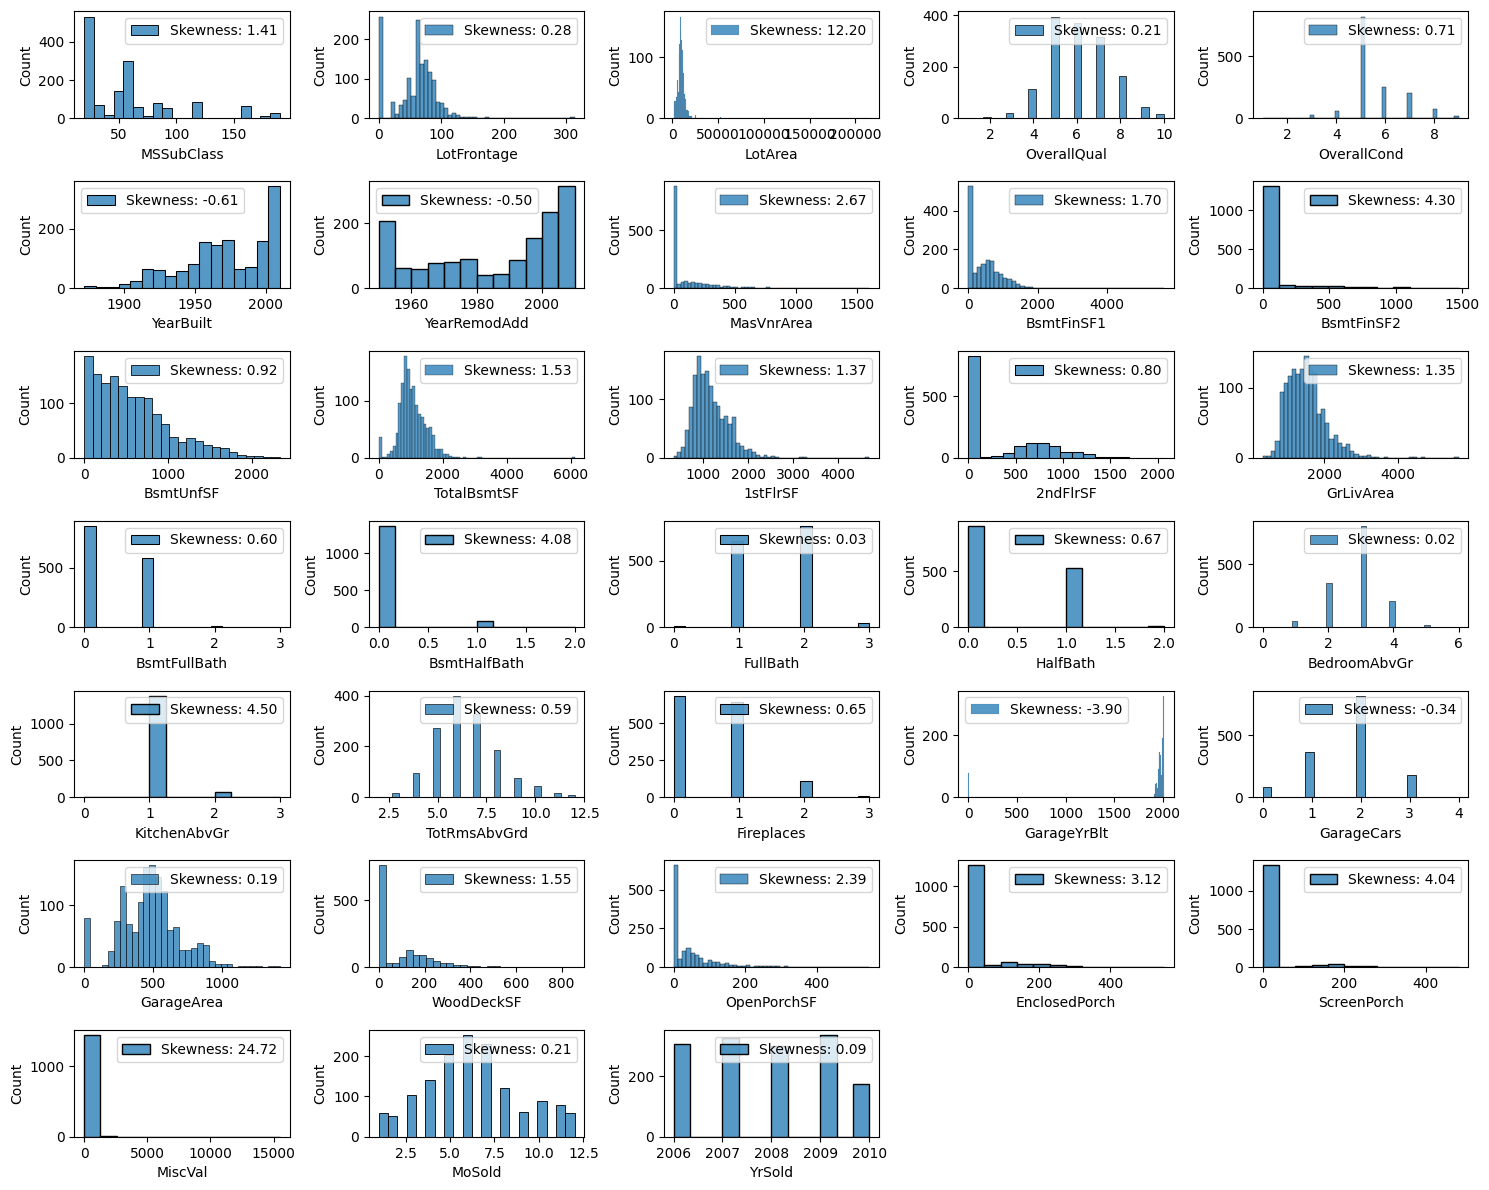

In [26]:
# Plot Train
plt.figure(figsize=(15, 12))
for n, col in enumerate(num_vars):
    ax = plt.subplot(7, 5, n + 1)
    sns.histplot(df_train[col], ax=ax, label = 'Skewness: %.2f'%(df_train[col].skew()))
    plt.legend(loc = 'best')
plt.tight_layout()

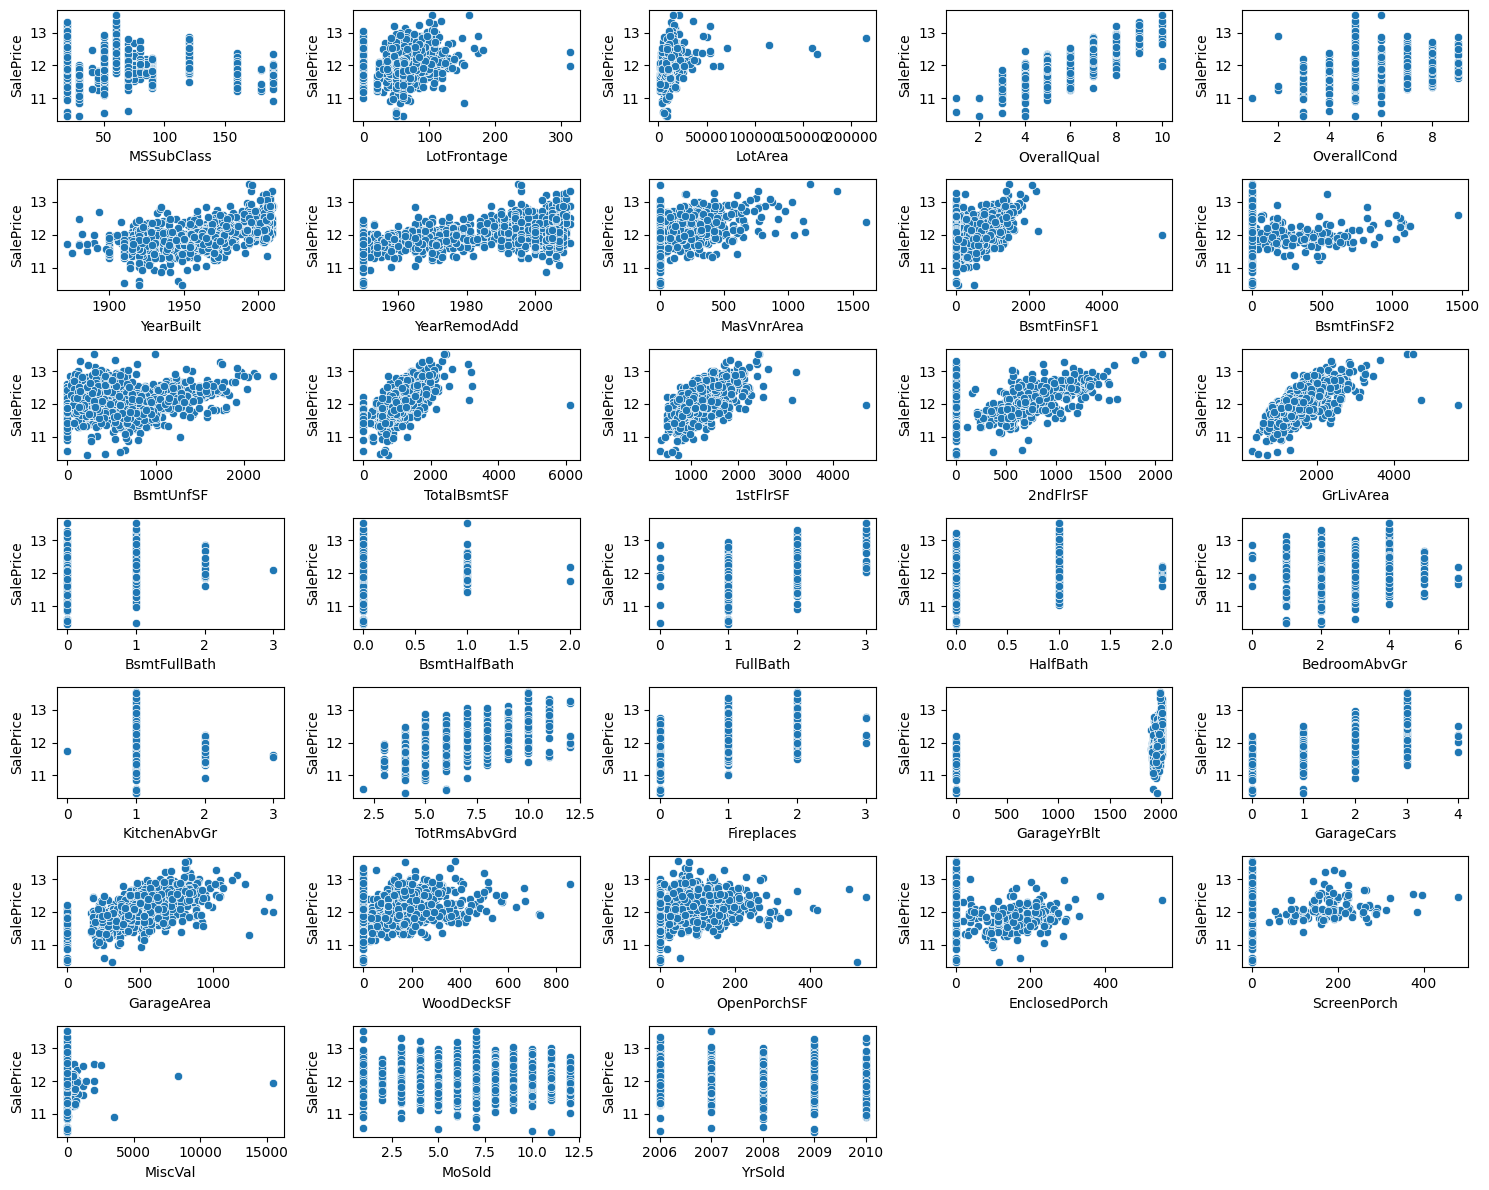

In [27]:
# Plot Train
plt.figure(figsize=(15, 12))
for n, col in enumerate(num_vars):
    ax = plt.subplot(7, 5, n + 1)
    sns.scatterplot(x=df_train[col], y=y_train, ax=ax)
plt.tight_layout()

# Data preprocessing

## Log Tranformation 

Numerical Variables with skew abs(> 0.75)

In [28]:
# Collect the skewness of each variable
skewed_vars_train = abs(df_train[num_vars].apply(lambda x: stats.skew(x)).sort_values(ascending=False))
skewed_vars_test  = abs(df_test[num_vars].apply(lambda x: stats.skew(x)).sort_values(ascending=False))

print('======== df_train ========')
print(skewed_vars_train[:5])
print('======== df_test =========')
print(skewed_vars_test[:5])

======== df_train ========
MiscVal         24.694456
LotArea         12.188624
KitchenAbvGr     4.499263
BsmtFinSF2       4.298261
BsmtHalfBath     4.076094
dtype: float64
======== df_test =========
MiscVal          20.054543
EnclosedPorch     4.664371
KitchenAbvGr      4.074860
BsmtFinSF2        4.038796
ScreenPorch       3.784349
dtype: float64


In [29]:
high_skew_train = skewed_vars_train[skewed_vars_train > 0.75]
high_skew_test  = skewed_vars_test[skewed_vars_test > 0.75]

In [30]:
# Applying a logarithmic transformation on Variables with high Skewness
skew_index_train = high_skew_train.index
skew_index_test = high_skew_test.index

for i in skew_index_train:
    df_train[i] = np.log1p(df_train[i])
    
for i in skew_index_test:
    df_test[i] = np.log1p(df_test[i])

In [31]:
check_skewed_vars_train = abs(df_train[num_vars].apply(lambda x: stats.skew(x)).sort_values(ascending=False))
check_skewed_vars_test  = abs(df_test[num_vars].apply(lambda x: stats.skew(x)).sort_values(ascending=False))

print('======== df_train ========')
print(check_skewed_vars_train[:5])
print('======== df_test =========')
print(check_skewed_vars_test[:5])

======== df_train ========
MiscVal         5.193829
BsmtHalfBath    3.906605
KitchenAbvGr    3.871468
ScreenPorch     3.178360
BsmtFinSF2      2.538130
dtype: float64
======== df_test =========
MiscVal         5.257221
BsmtHalfBath    3.633844
KitchenAbvGr    3.146960
ScreenPorch     2.768934
BsmtFinSF2      2.406091
dtype: float64


## Feature encoding

### Ordinal Variables 
LotShape, LandSlope, OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtCond,
BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, Electrical, KitchenQual, FireplaceQu, GarageFinish, GarageQual,
GarageCond, PavedDrive, Fence

In [32]:
df_train['LotShape'] = df_train['LotShape'].map({'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}).astype('int8')
df_test['LotShape'] = df_test['LotShape'].map({'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}).astype('int8')

df_train['LandSlope'] = df_train['LandSlope'].map({'Sev': 0, 'Mod': 1, 'Gtl': 2}).astype('int8')
df_test['LandSlope'] = df_test['LandSlope'].map({'Sev': 0, 'Mod': 1, 'Gtl': 2}).astype('int8')

df_train['ExterQual'] = df_train['ExterQual'].map({'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}).astype('int8')
df_test['ExterQual'] = df_test['ExterQual'].map({'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}).astype('int8')

df_train['ExterCond'] = df_train['ExterCond'].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}).astype('int8')
df_test['ExterCond'] = df_test['ExterCond'].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}).astype('int8')

df_train['BsmtQual'] = df_train['BsmtQual'].map({'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}).astype('int8')
df_test['BsmtQual'] = df_test['BsmtQual'].map({'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}).astype('int8')

df_train['BsmtCond'] = df_train['BsmtCond'].map({'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4}).astype('int8')
df_test['BsmtCond'] = df_test['BsmtCond'].map({'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4}).astype('int8')

df_train['BsmtExposure'] = df_train['BsmtExposure'].map({'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}).astype('int8')
df_test['BsmtExposure'] = df_test['BsmtExposure'].map({'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}).astype('int8')

df_train['BsmtFinType1'] = df_train['BsmtFinType1'].map({'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}).astype('int8')
df_test['BsmtFinType1'] = df_test['BsmtFinType1'].map({'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}).astype('int8')

df_train['BsmtFinType2'] = df_train['BsmtFinType2'].map({'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4,'ALQ': 5, 'GLQ': 6}).astype('int8')
df_test['BsmtFinType2'] = df_test['BsmtFinType2'].map({'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}).astype('int8')

df_train['HeatingQC'] = df_train['HeatingQC'].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}).astype('int8')
df_test['HeatingQC'] = df_test['HeatingQC'].map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}).astype('int8')

df_train['Electrical'] = df_train['Electrical'].map({'FuseP': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3}).astype('int8')
df_test['Electrical'] = df_test['Electrical'].map({'FuseP': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3}).astype('int8')

df_train['KitchenQual'] = df_train['KitchenQual'].map({'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}).astype('int8')
df_test['KitchenQual'] = df_test['KitchenQual'].map({'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}).astype('int8')

df_train['FireplaceQu'] = df_train['FireplaceQu'].map({'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype('int8')
df_test['FireplaceQu'] = df_test['FireplaceQu'].map({'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype('int8')

df_train['GarageFinish'] = df_train['GarageFinish'].map({'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}).astype('int8')
df_test['GarageFinish'] = df_test['GarageFinish'].map({'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}).astype('int8')

df_train['GarageQual'] = df_train['GarageQual'].map({'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype('int8')
df_test['GarageQual'] = df_test['GarageQual'].map({'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype('int8')

df_train['GarageCond'] = df_train['GarageCond'].map({'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype('int8')
df_test['GarageCond'] = df_test['GarageCond'].map({'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype('int8')

df_train['PavedDrive'] = df_train['PavedDrive'].map({'N': 0, 'P': 1, 'Y': 2}).astype('int8')
df_test['PavedDrive'] = df_test['PavedDrive'].map({'N': 0, 'P': 1, 'Y': 2}).astype('int8')

df_train['Fence'] = df_train['Fence'].map({'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}).astype('int8')
df_test['Fence'] = df_test['Fence'].map({'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}).astype('int8')

## Nominal Variables

In [33]:
print('Before:', df_train.shape)
df_train = pd.get_dummies(df_train, drop_first=True)
print('After:', df_train.shape)

Before: (1446, 70)
After: (1446, 174)


In [34]:
print('Before:', df_test.shape)
df_test = pd.get_dummies(df_test, drop_first=True)
print('After:', df_test.shape)

Before: (1459, 70)
After: (1459, 174)


## Optimize Memory

In [35]:
def reduce_memory(df,col):
    mx = df[col].max()
    mn = df[col].min()
    if (mn > -128) & (mx < 127):
            df[col] = df[col].astype('int8')
    elif (mn > -32768) & (mx < 32767):
        df[col] = df[col].astype('int16')
    else:
        df[col] = df[col].astype('int32')

int_list = list(df_train.select_dtypes(include='integer').columns)        

for col in int_list:
    reduce_memory(df_train, col)
    
for col in int_list:
    reduce_memory(df_test, col)

## Correlação

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [ ]:
#corr_features = correlation(df_train, 0.95)
#len(set(corr_features))
#print('correlated features: ', len(set(corr_features)))

In [ ]:
#print('correlated features are: ', corr_features)

In [ ]:
#df_train.drop(corr_features, axis=1, inplace=True)
#df_test.drop(corr_features, axis=1, inplace=True)

## Split training data

In [ ]:
#X = df_train
#y = y_train

# Modeling

## Cross Validation

In [36]:
#Validation function
n_folds = 20
cv_scores, cv_std = [], []

def rmse(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, df_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


# Função para executar a validação cruzada e armazenar o score e o desvio padrão de cada modelo
def apply_learning_algorithm(model):
    score = rmse(model)
    cv_scores.append(score.mean())
    cv_std.append(score.std())

## Models

In [37]:
models = [make_pipeline(RobustScaler(), LinearRegression()),
          make_pipeline(RobustScaler(), BayesianRidge()),
          make_pipeline(RobustScaler(), Lasso()),
          make_pipeline(RobustScaler(), ElasticNet()),
          KernelRidge(),
          RandomForestRegressor(),
          XGBRegressor(),
          LGBMRegressor()]

In [38]:
baseline_models = [
    'LinearRegression',
    'BayesianRidge', 
    'LassoRegressor',
    'ElasticNetRegressor',
    'KernelRidgeRegressor',
    'RandomForestRegressor',
    'XGBRegressor',
    'LGBMRegressor']

In [39]:
for model in models:
    apply_learning_algorithm(model)

In [40]:
final_cv_score = pd.DataFrame(baseline_models, columns = ['Models'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_std
final_cv_score.sort_values(by='RMSE_mean')

,Models,RMSE_mean,RMSE_std
1,BayesianRidge,0.124327,0.025543
4,KernelRidgeRegressor,0.125771,0.024972
7,LGBMRegressor,0.128544,0.020686
0,LinearRegression,0.128996,0.025478
5,RandomForestRegressor,0.139667,0.020666
6,XGBRegressor,0.143716,0.025344
3,ElasticNetRegressor,0.374715,0.032950
2,LassoRegressor,0.374851,0.033313


### Hyperparameter tuning for best model

In [41]:
from sklearn.model_selection import GridSearchCV
kf = KFold(5, shuffle=True, random_state=42)

PARAMETERS = {'learning_rate': [0.01, 0.04, 0.1, 0.15, 0.2, 0.25],
              'max_depth': [8,9,10,11,12,13,-1],
              'n_estimators': [1000, 2000, 3000],
              'colsample_bytree' : [0.01,0.1,0.5,1,1.5,2]}

# initialise an XGBoost classifier
estimator = LGBMRegressor()

# initialise GridSearchCV
model = GridSearchCV(estimator=estimator,
                     param_grid=PARAMETERS,
                     scoring="neg_mean_squared_error",
                     n_jobs=-1,
                     cv= kf,
                     verbose=1)

# fit model
model.fit(df_train, y_train, verbose=False)

# print out the best hyperparameters
print(model.best_params_)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits
{'colsample_bytree': 0.1, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 3000}


In [42]:
lgb = LGBMRegressor(learning_rate=0.01, max_depth=8, n_estimators=3000, colsample_bytree=0.1)
lgb.fit(df_train, y_train)

LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=8,
              n_estimators=3000)

# Predict and Submission

In [43]:
# Predict
y_pred = lgb.predict(df_test)
y_pred = np.expm1(y_pred) # necessário retornar os valores que estão na base logarítmica

In [44]:
# Submit
ss['SalePrice'] = y_pred
ss.to_csv('lgb.csv', index=False)